In [1]:
import os, glob, numpy as np, matplotlib.pyplot as plt, pandas as pd 
from tensorboard.backend.event_processing import event_accumulator 
from collections import defaultdict 
from matplotlib.pyplot import figure 

In [17]:
LOG_DIRS = ["../debug_logs/simple-tag-1_adv-2_obs", "../debug_logs/simple_spread_all_baselines"] 
LOG_DIRS = ["../debug_logs/simple_spread_all_baselines"] 
LOG_DIRS = ["../debug_logs/cp_mpe_logs"] 
LOG_DIRS = ["../debug_logs/simple_spread_all_baselines", "../debug_logs/cp_mpe_logs", "../final_logs"] 

SAVE_NUMPY = False  

STORE_EVERYTHING_SIZE_GUIDANCE = {
    'compressedHistograms': 0, 
    'images': 0, 
    'audio': 0, 
    'scalars': 0, 
    'histograms': 0, 
} 

INITIAL_CUT = 0  
CUT = 29000 
SMOOTH = 2000   

In [18]:
def get_values(filename): 
    ea = event_accumulator.EventAccumulator(filename, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    ea.Reload()
    res = {} 
    # print(ea.Tags()) 
    for s in ea.Tags()["scalars"]: res[s] = pd.DataFrame(ea.Scalars(tag=s))['value'].to_numpy() 
    return res  

In [19]:
if SAVE_NUMPY: 
    logs = glob.glob(os.path.join(LOG_DIRS[-1], "*/**/event*"), recursive=True) 
    for log in logs: 
        print(log) 
        res = get_values(log)
        path = "/".join(log.split("/")[:-1]) 
        for key,value in res.items(): 
            if not os.path.isdir(path+"/rewards/"): os.mkdir(path+"/rewards/") 
            with open(path+"/rewards/"+key+".npy", "wb") as f: 
                np.save(f, value) 

In [23]:
def save_averaged_curves(name="self_reward", save=False): 
    logs = [] 
    [logs.extend(glob.glob(os.path.join(log_dir, "*/**/"+name+".npy"), recursive=True)) for log_dir in LOG_DIRS] 
#     print(logs) 

    exps = set() 
#     [exps.add("--".join(l.split("/")[-3].split("--")[:-1])) for l in logs] 
#     [exps.add("--".join(l.split("/")[-2].split("--")[:-1])) for l in logs] 
    [exps.add(l.split("/")[-3]) for l in logs] 
    print("Exps\n", exps) 

    vals = [] 
    for e in exps: 
        print("exp:", e) 
        vals = [] 
        for l in logs: 
            if e in l: 
                x = np.load(l) 
                if (x.shape[0]>CUT): 
                    vals.append(x[INITIAL_CUT:CUT]) 
        vals = np.array(vals)
        r_mean = np.mean(vals, axis=0)
        r_std = np.std(vals, axis=0)/np.sqrt(20) 
        if save: 
            if not os.path.exists("../final_curves/"+e):
                os.makedirs("../final_curves/"+e) 
            with open('../final_curves/'+e+"/mean.npy", 'wb') as f:
                np.save(f, r_mean) 
            with open('../final_curves/'+e+"/std.npy", 'wb') as f:
                np.save(f, r_std) 
save_averaged_curves(name="arr", save=True) 

Exps
 {'cp-penultimate', 'noam-main', 'cp-padding', 'cp_mpe_logs', 'cp-logits', 'noam-naive', 'giam'}
exp: cp-penultimate
exp: noam-main
exp: cp-padding
exp: cp_mpe_logs
exp: cp-logits
exp: noam-naive
exp: giam


In [9]:
def running_mean(X, N=150):
    cumsum = np.cumsum(np.insert(X, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N) 

{'cp-penultimate', 'simple_spread_v2--toam', 'simple_spread_v2--noam', 'noam-main', 'cp-padding', 'cam_actions', 'simple_spread_v2--taam', 'simple_spread_v2--giam', 'cp-logits', 'noam-naive', 'giam'}


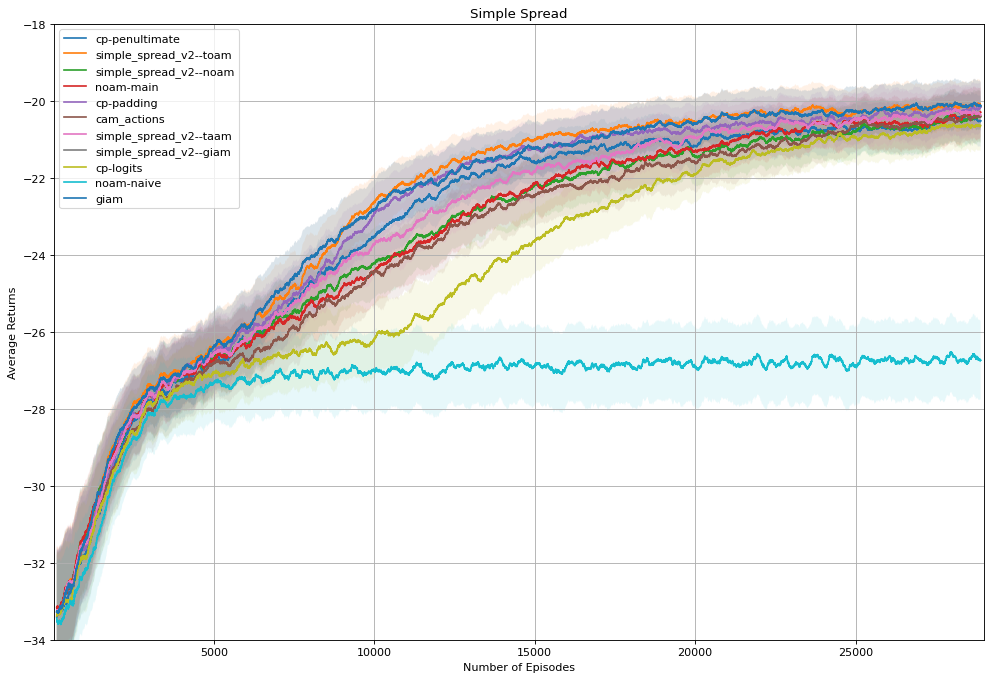

In [8]:
def plot(name="self_reward"): 
    logs = [] 
    [logs.extend(glob.glob(os.path.join(log_dir, "*/**/"+name+".npy"), recursive=True)) for log_dir in LOG_DIRS] 
    # print(logs) 

    exps = set() 
    [exps.add("--".join(l.split("/")[-3].split("--")[:-1])) for l in logs] 
#     if exps == {''}: [exps.add("--".join(l.split("/")[-2].split("--")[:-1])) for l in logs] 
    print("Exps\n", exps) 

    from matplotlib.pyplot import figure
    vals = [] 
    figure(figsize=(15, 10), dpi=80) 
    for e in exps: 
        print("exp:", e) 
        vals = [] 
        for l in logs: 
            if e in l: 
                x = np.load(l) 
                if (x.shape[0]>CUT): 
                    vals.append(x[INITIAL_CUT:CUT]) 
        vals = np.array(vals)
        r_mean = np.mean(vals, axis=0)
        r_std = np.std(vals, axis=0)/np.sqrt(20) 
        x = np.arange(len(r_mean))+1 
        plt.plot(running_mean(x), running_mean(r_mean), label=e) 
        plt.fill_between(running_mean(x), running_mean(r_mean+r_std), running_mean(r_mean-r_std), alpha=0.1) 
    plt.title("Simple Tag: " + name) 
    plt.xlabel("Number of Episodes")
    plt.ylabel("Average Returns")
    plt.xlim((10, CUT)) 
    # plt.ylim((-34, -18)) 
    plt.grid()
    plt.legend() 
    plt.show() 
    plt.close() 
# for n in ["adversary_0_reward", "agent_0_reward", "agent_1_reward", "good_team_reward", "self_reward"]: 
for n in ["agent_0_reward", "agent_1_reward", "good_team_reward", "self_reward"]: 
# for n in ["arr"]: 
    plot(n) 